In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mobius import Planner, SequenceGA
from mobius import Map4Fingerprint
from mobius import GPModel, ExpectedImprovement, TanimotoSimilarityKernel
from mobius import LinearPeptideEmulator
from mobius import homolog_scanning, alanine_scanning

In [4]:
# Create the linear peptide emulators
hla_a32 = LinearPeptideEmulator('IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-32:15-9.txt')
hla_a26 = LinearPeptideEmulator('IEDB_MHC_I-2.9_matx_smm_smmpmbec/smmpmbec_matrix/HLA-A-26:02-9.txt')

In [5]:
# Predicted to bind to both HLA-A*32:15 and HLA-A*26:02 with
# pIC50 of 3.00 and 3.77, respectively.
lead_peptide = 'PEPTIDE1{Q.F.V.R.T.N.D.I.I}$$$$V2.0'
seed_library = [lead_peptide]

for seq in alanine_scanning(lead_peptide):
    seed_library.append(seq)

for seq in homolog_scanning(lead_peptide):
    seed_library.append(seq)

    if len(seed_library) >= 96:
        print('Reach max. number of peptides allowed.')
        break

# Virtually test the seed library using the MHC emulators
hla_a32_scores = hla_a32.score(seed_library)
hla_a26_scores = hla_a26.score(seed_library)
pic50_seed_library = np.column_stack((hla_a32_scores, hla_a26_scores))

Reach max. number of peptides allowed.


In [6]:
map4 = Map4Fingerprint(input_type='helm', dimensions=4096, radius=1)

# Create the Gaussian Process models
gpmodel_a32 = GPModel(kernel=TanimotoSimilarityKernel(), transform=map4)
gpmodel_a26 = GPModel(kernel=TanimotoSimilarityKernel(), transform=map4)

In [7]:
# .. pass them to the acquisition function
# Here we want to both minimize the pIC50 values for HLA-A*32:15 and HLA-A*26:02
# so we set the `maximize` argument to `False` for both models. But you can also
# set it to `True` for one of the models, and `False` for the other one, depending
# on your optimization problem.
acq = ExpectedImprovement([gpmodel_a32, gpmodel_a26], maximize=[False, False])

In [8]:
# Instead of using the classic GA, we are going to use the SMS-EMOA algorithm
optimizer = SequenceGA(algorithm='SMSEMOA', period=15)
ps = Planner(acq, optimizer)

In [10]:
peptides = seed_library.copy()
pic50_scores = pic50_seed_library.copy()

data = [(0, p, s[0], s[1]) for p, s in zip(peptides, pic50_scores)]

for i in range(5):
    suggested_peptides, _ = ps.recommend(peptides, pic50_scores, batch_size=96)

    # Virtually test the suggested peptides using the MHC emulators
    # This is for benchmarking or demonstration purposes only and
    # should be replaced with actual lab experiments.
    exp_values = []
    for emulator in [hla_a32, hla_a26]:
        values = np.asarray(emulator.score(suggested_peptides))
        exp_values.append(values)
    exp_values = np.stack(exp_values, axis=1)

    # Add the suggested peptides to the library, and start over
    peptides = np.concatenate([peptides, suggested_peptides])
    pic50_scores = np.vstack([pic50_scores, exp_values])
    data.extend([(i + 1, p, s[0], s[1]) for p, s in zip(suggested_peptides, exp_values)])

df = pd.DataFrame(data=data, columns=('iter', 'polymer', 'exp_value_a32', 'exp_value_a26'))

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        0 |      6 |             - |             -
     2 |      500 |     11 |  7.912373E+03 |         ideal
     3 |     1000 |     14 |  0.4940479971 |         ideal
     4 |     1500 |     12 |  0.0235893586 |             f
     5 |     2000 |     15 |  0.0146754632 |             f
     6 |     2500 |     16 |  0.0123450098 |         ideal
     7 |     3000 |     23 |  0.0149561200 |             f
     8 |     3500 |     15 |  0.0039977944 |         ideal
     9 |     4000 |     15 |  0.1028017238 |         ideal
    10 |     4500 |     25 |  0.0151334390 |             f
    11 |     5000 |     21 |  0.0190857160 |             f
    12 |     5500 |     23 |  0.3937026610 |         ideal
    13 |     6000 |     29 |  0.0116091193 |             f
    14 |     6500 |     34 |  0.0060351801 |             f
    15 |     7000 |     34 |  0.0073082073 |             f
    16 |     7500 |     36 |  0.0186988833 |         ide

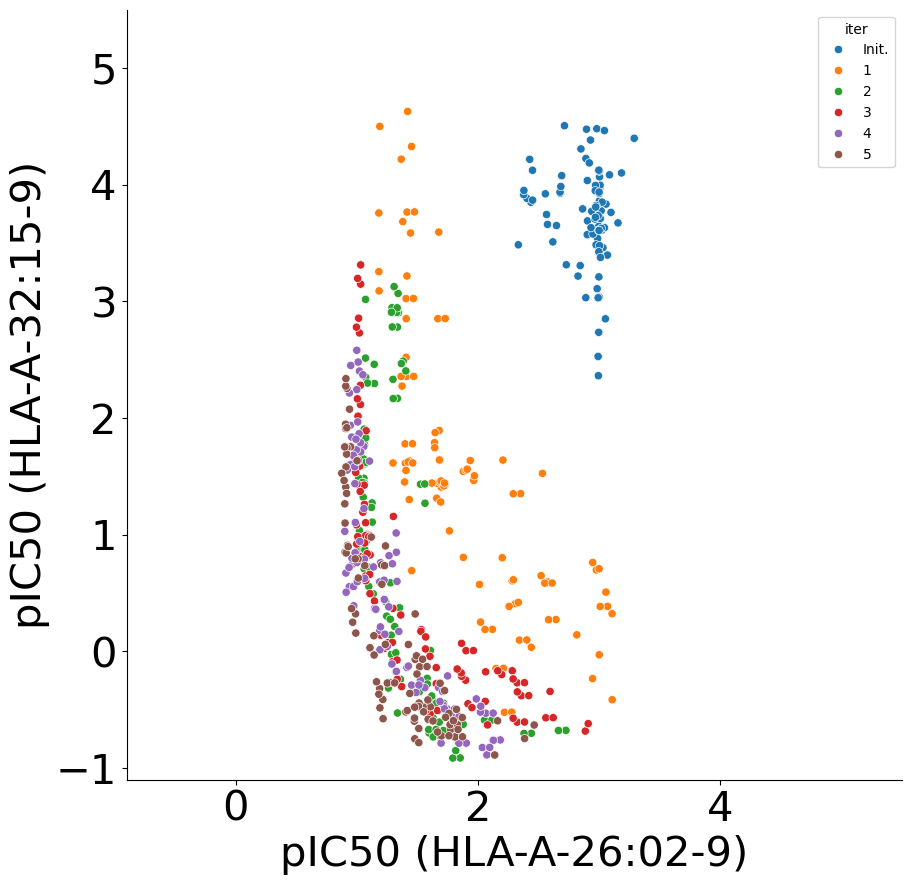

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))

# pandas dataframe (df) columns: iter, peptide, exp_value, methods/protocols
df['iter'] = df['iter'].replace({0: 'Init.', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'})

sns.scatterplot(x='exp_value_a32', y='exp_value_a26', hue='iter', data=df, ax=ax)

ax.set_xlim([-0.9, 5.5])
ax.set_ylim([-1.1, 5.5])
ax.set_ylabel('pIC50 (HLA-A-32:15-9)', fontsize=30)
ax.set_xlabel('pIC50 (HLA-A-26:02-9)', fontsize=30)
ax.xaxis.set_tick_params(labelsize=30)
ax.yaxis.set_tick_params(labelsize=30)

sns.despine()
plt.show()